In [67]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rcParams['figure.dpi']= 200
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month

In [2]:
MAINDIR = os.getcwd().rsplit('/', 1)[0]
file = os.path.join(MAINDIR, 'data/analysis', 'vendor_item_period.csv')

df = pd.read_csv(file, index_col = False)
df = df.drop(df.columns[0], axis=1)

In [5]:
me = pd.read_pickle(os.path.join(MAINDIR, 'data/analysis', 'market_entry.pickle'))

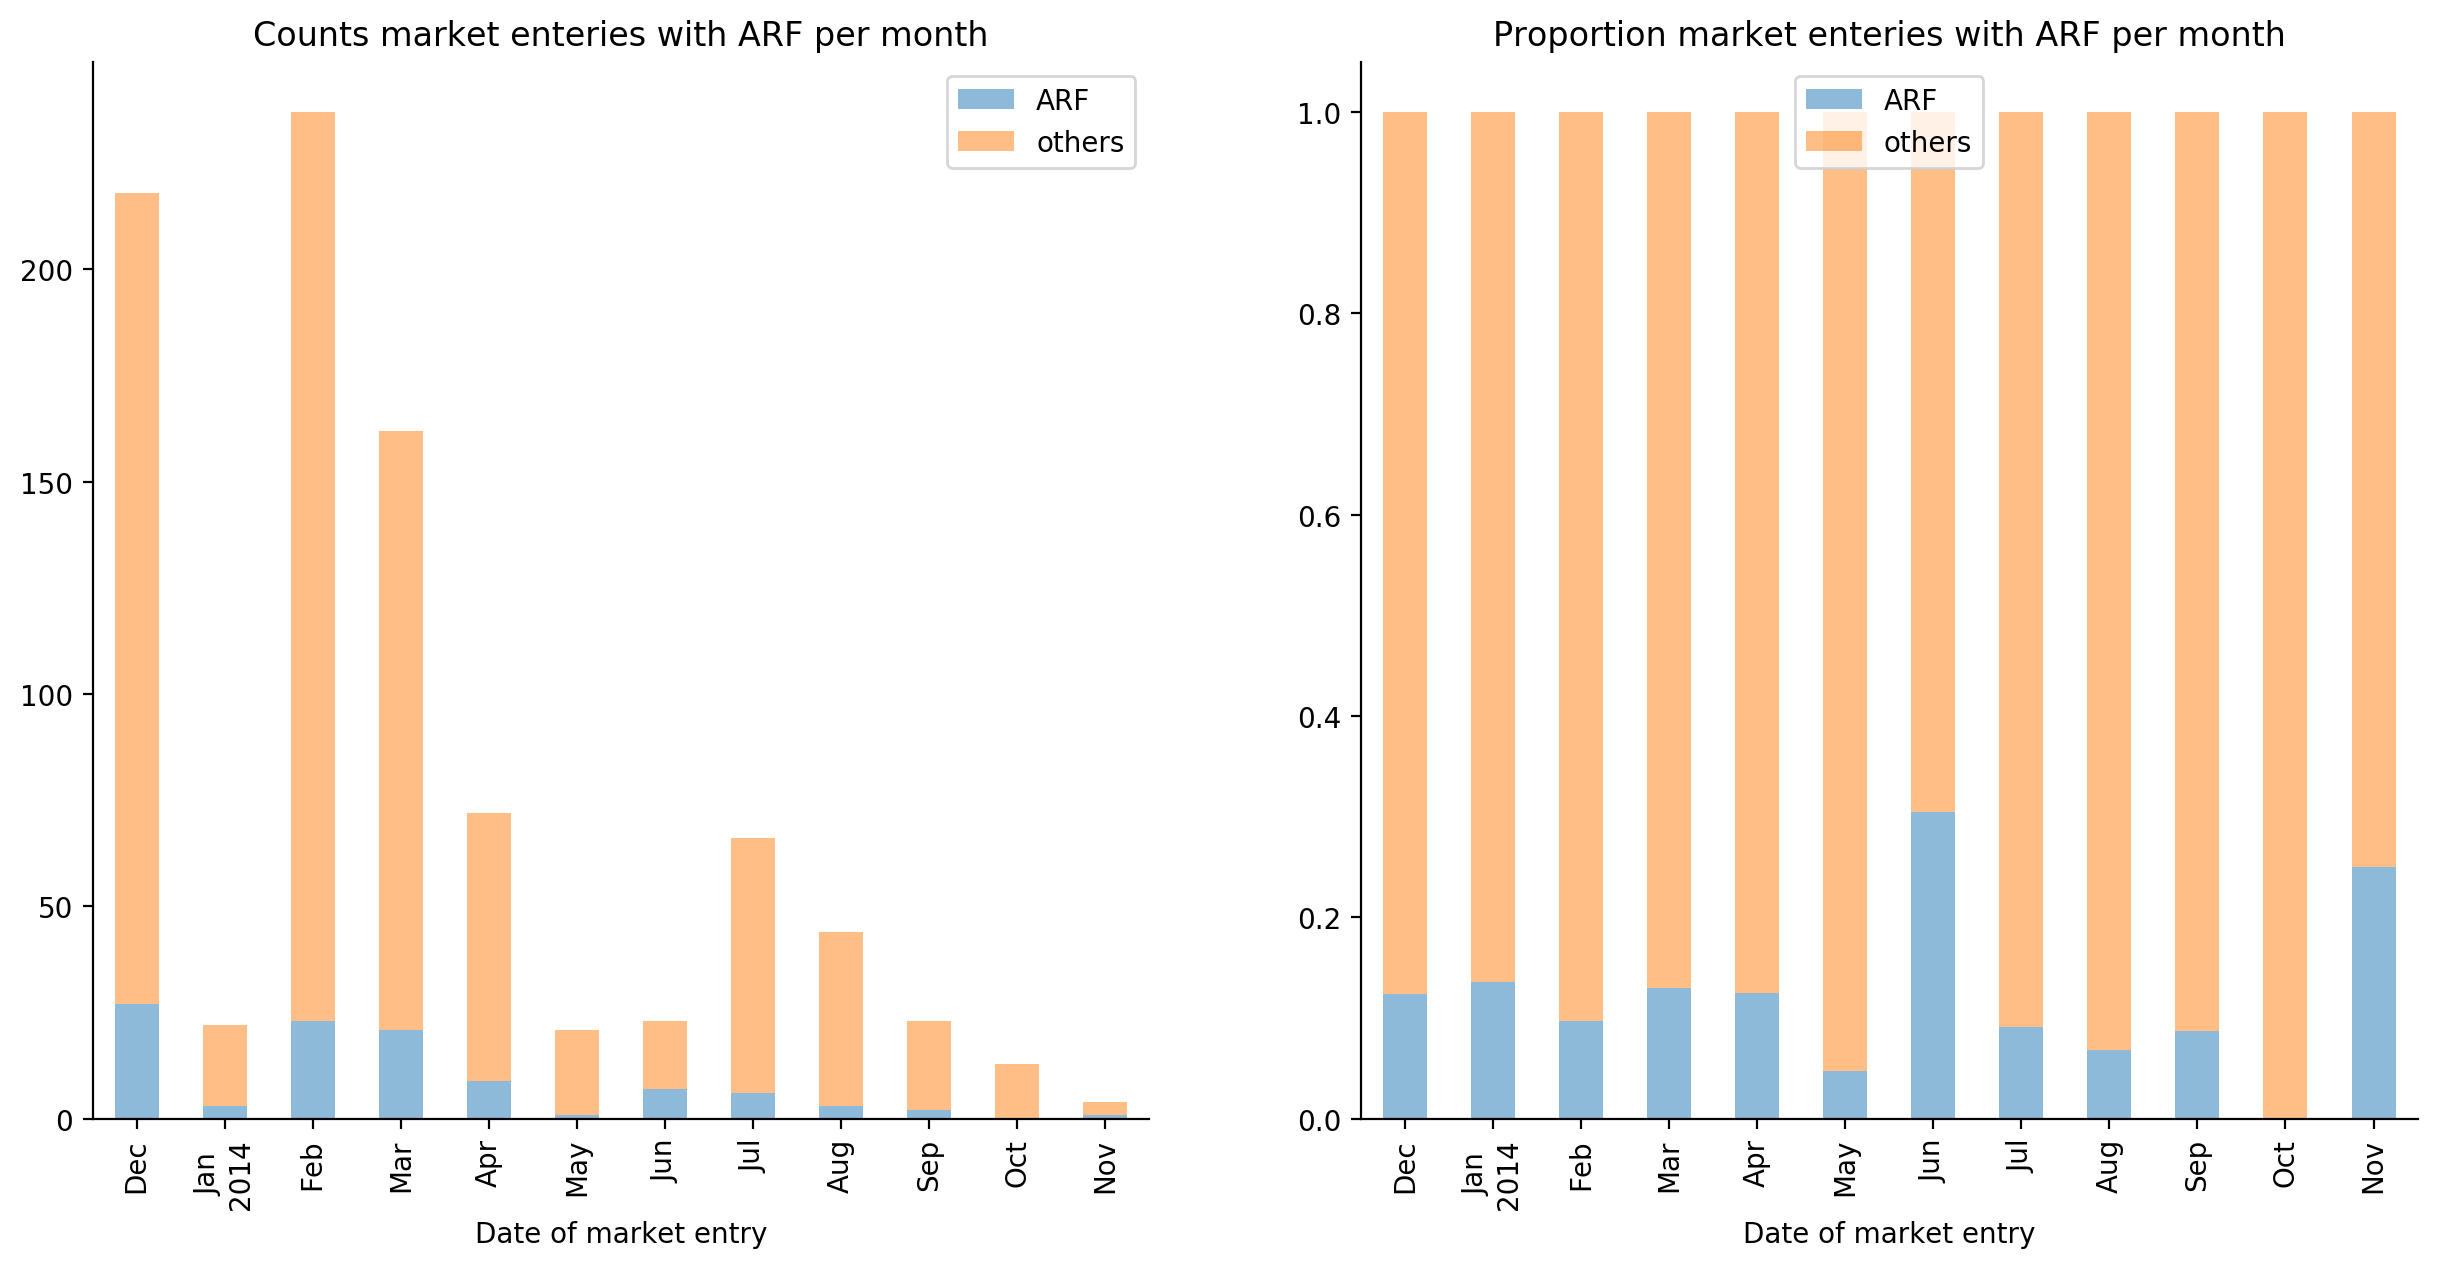

In [88]:
fig, ax = plt.subplots(ncols = 2, figsize=(15, 7))

counts = me.sort_values('stime_dt').groupby('vendor').first()\
    .groupby('stime_dt')['arf'].agg(['sum','count'])\
    .groupby(pd.Grouper(freq='M')).sum()\
    .assign(count = lambda x: x['count'] - x['sum'])\
    .set_axis(['ARF','others'], axis=1, inplace=False)

counts.plot.bar(ax = ax[0], alpha = .5, stacked = True)

ax[0].set_xlabel('Date of market entry')
ax[0].set_xticklabels(map(lambda x: line_format(x), counts.index))
ax[0].set_title('Counts market enteries with ARF per month')

proportions = me.sort_values('stime_dt').groupby('vendor').first()\
    .groupby('stime_dt')['arf'].agg(['sum','count'])\
    .groupby(pd.Grouper(freq='M')).sum()\
    .assign(sum = lambda x: x['sum'] / x['count'],
            count = lambda x: 1 - x['sum'])\
    .set_axis(['ARF','others'], axis=1, inplace=False)

proportions.plot.bar(ax = ax[1], alpha = .5, stacked = True)

ax[1].set_xlabel('Date of market entry')
ax[1].set_xticklabels(map(lambda x: line_format(x), counts.index))
ax[1].set_title('Proportion market enteries with ARF per month')

plt.show()

In [92]:
df = pd.read_pickle(os.path.join(MAINDIR, 'data/analysis', 'vendor_week.pickle'))
df = df.merge(df.groupby('vendor')['me_min'].min().rename('me'), on = 'vendor')

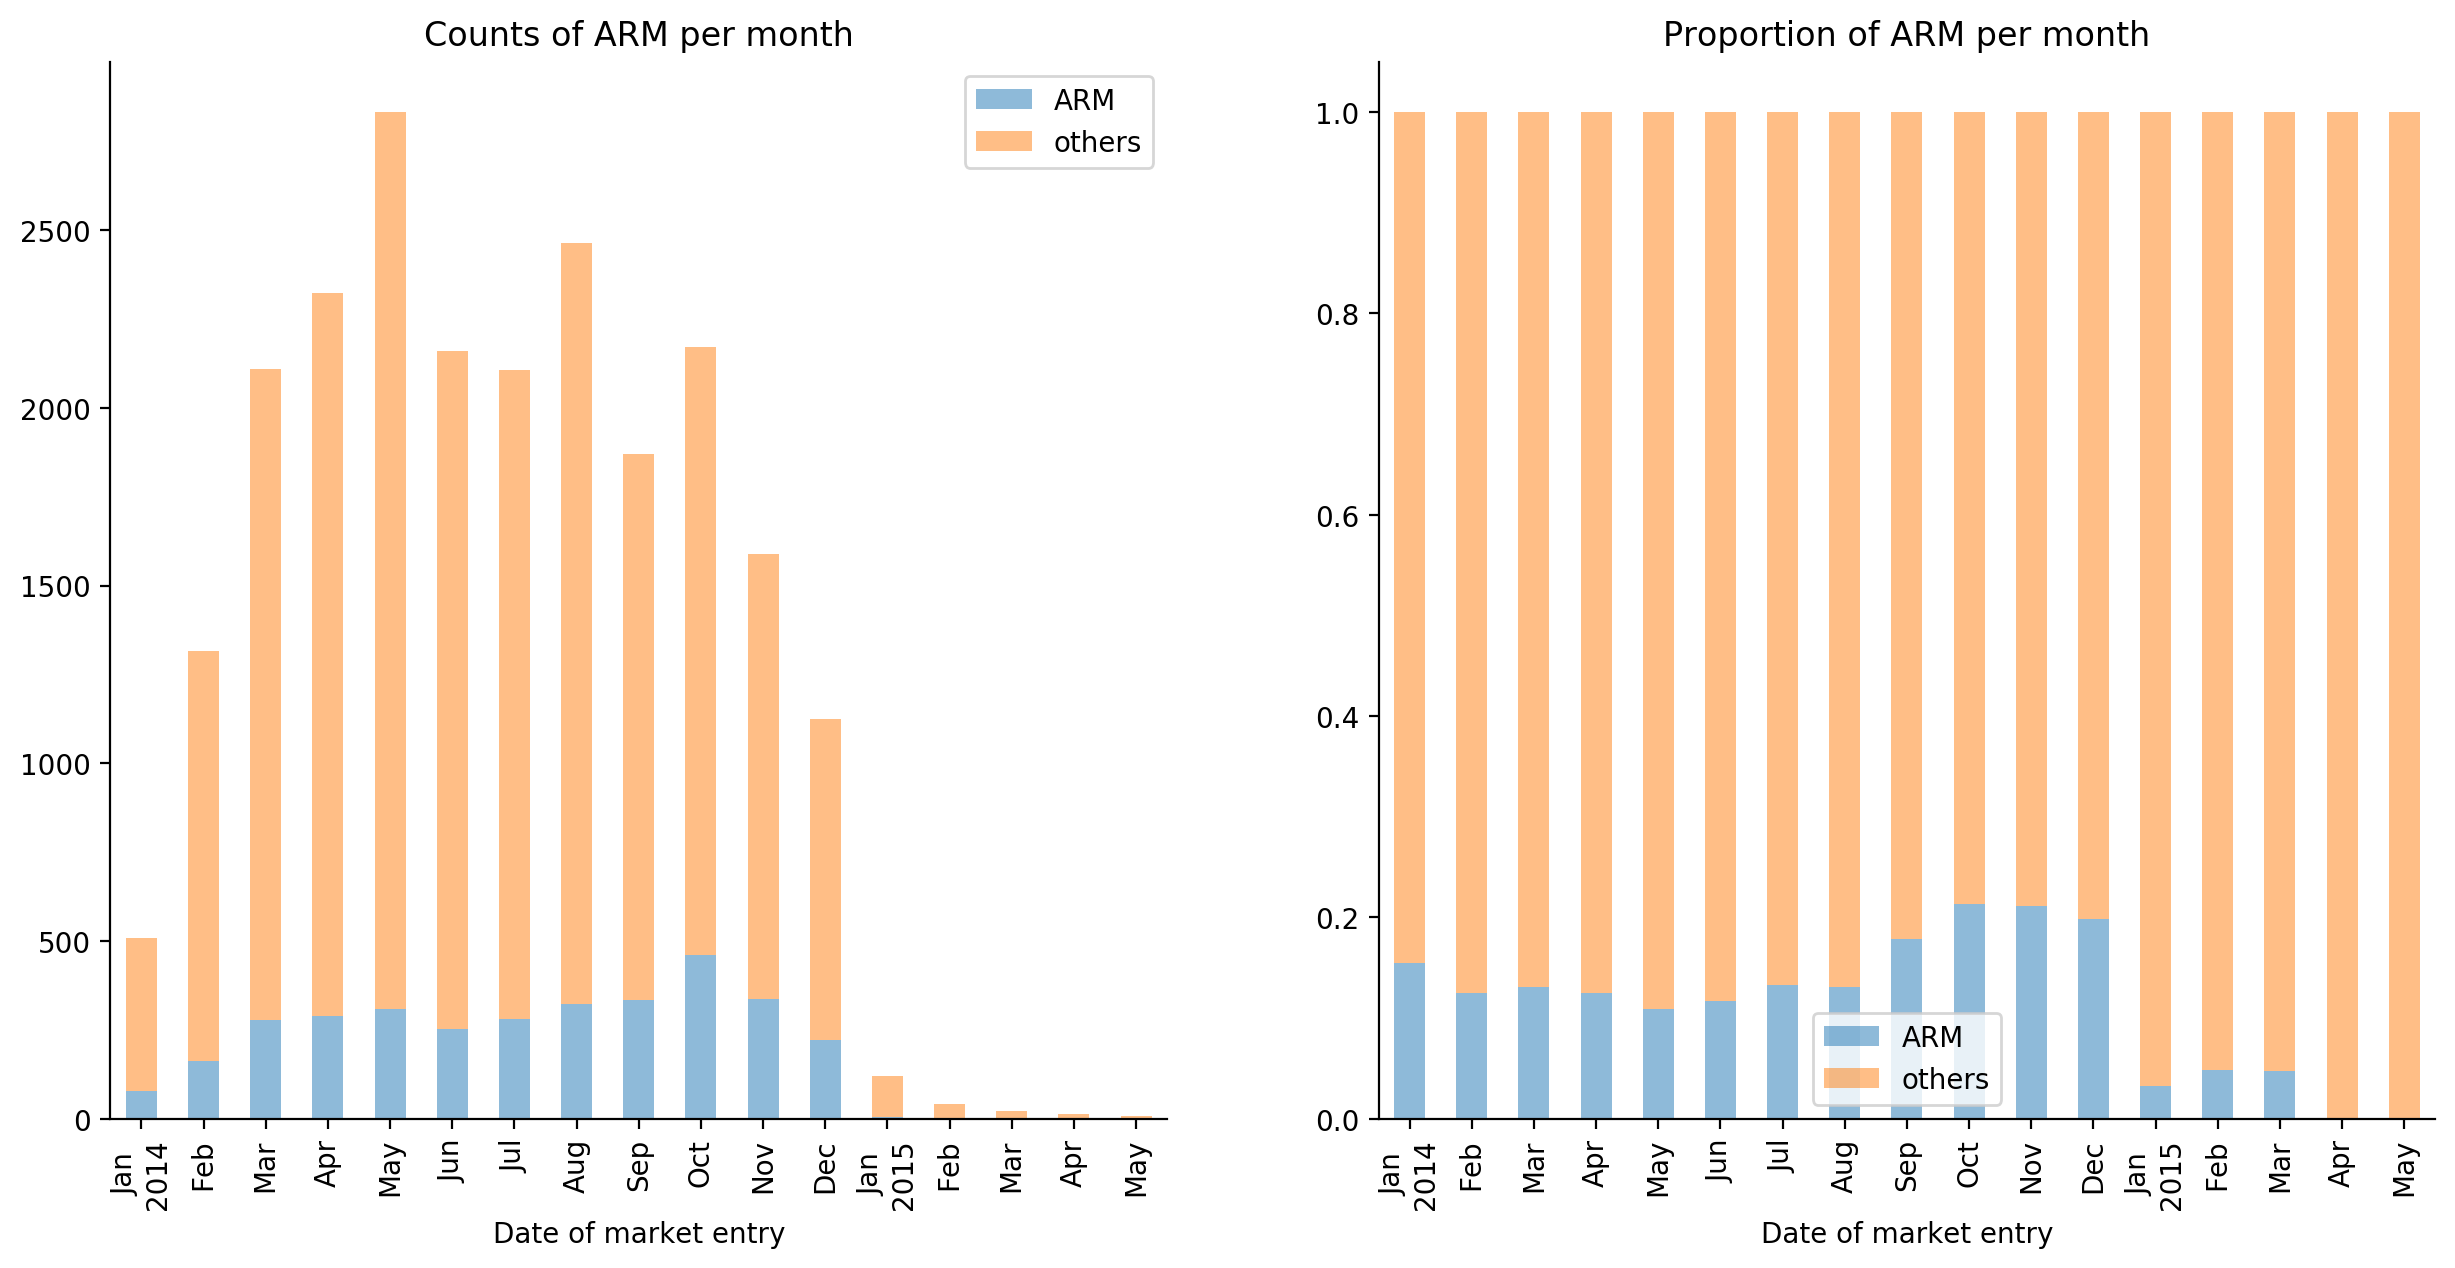

In [206]:
fig, ax = plt.subplots(ncols = 2, figsize=(15, 7))

counts = df.rename({'arm_maxw_shift': 'arm'}, axis = 1)\
    .assign(week = lambda x: x['w'] + x['me'],
            date = lambda x: me['stime_dt'].min() + pd.to_timedelta(x['week'], unit='w'))\
    .groupby('date')['arm'].agg(['sum','count']).astype('int')\
    .groupby(pd.Grouper(freq='M')).sum()\
    .assign(count = lambda x: x['count'] - x['sum'])\
    .set_axis(['ARM','others'], axis=1, inplace=False)

counts.plot.bar(ax = ax[0], alpha = .5, stacked = True)

ax[0].set_xlabel('Date of market entry')
ax[0].set_xticklabels(map(lambda x: line_format(x), counts.index))
ax[0].set_title('Counts of ARM per month')

proportions = df.rename({'arm_maxw_shift': 'arm'}, axis = 1)\
    .assign(week = lambda x: x['w'] + x['me'],
            date = lambda x: me['stime_dt'].min() + pd.to_timedelta(x['week'], unit='w'))\
    .groupby('date')['arm'].agg(['sum','count']).astype('int')\
    .groupby(pd.Grouper(freq='M')).sum()\
    .assign(sum = lambda x: x['sum'] / x['count'],
            count = lambda x: 1 - x['sum'])\
    .set_axis(['ARM','others'], axis=1, inplace=False)

proportions.plot.bar(ax = ax[1], alpha = .5, stacked = True)

ax[1].set_xlabel('Date of market entry')
ax[1].set_xticklabels(map(lambda x: line_format(x), counts.index))
ax[1].set_title('Proportion of ARM per month')

plt.show()

In [105]:
me['stime_dt'].min()

Timestamp('2013-12-20 00:00:00')

In [202]:
# interseller cut-offs
t_cut_per_seller = df.groupby('vendor')['delta_t_m'].quantile(.5).to_dict()
s_cut_per_seller = df.groupby('vendor')['delta_t_s'].quantile(.5).to_dict()
p_cut_per_seller = df.groupby('vendor')['price_usd_m'].quantile(.5).to_dict()
t_cut = df['delta_t_m'].quantile(1/2)
p_cut = df['price_usd_m'].quantile(1/2)
s_cut = df['delta_t_s'].quantile(1/2)

df = df\
    .assign(t_low_s = lambda x: x['delta_t_m'] < x['vendor'].map(t_cut_per_seller),
            p_low_s = lambda x: x['price_usd_m'] < x['vendor'].map(p_cut_per_seller),
            s_low_s = lambda x: x['delta_t_s'] < x['vendor'].map(s_cut_per_seller))\
    .assign(arm_i = lambda x: (x[['t_low_s', 'p_low_s', 's_low_s']].all(axis = 1)))\
    .drop(['t_low_s', 'p_low_s', 's_low_s'], axis = 1)

df = df\
    .assign(t_low_s = lambda x: x['delta_t_m'] < x['vendor'].map(t_cut_per_seller),
            p_low_s = lambda x: x['price_usd_m'] < x['vendor'].map(p_cut_per_seller),
            s_low_s = lambda x: x['delta_t_s'] < x['vendor'].map(s_cut_per_seller),
            p_low   = lambda x: x['price_usd_m'] < p_cut)\
    .assign(arm_p = lambda x: (x[['t_low_s', 'p_low_s', 's_low_s', 'p_low']].all(axis = 1)))\
    .drop(['t_low_s', 'p_low_s', 's_low_s', 'p_low'], axis = 1)

df = df\
    .assign(t_low_s = lambda x: x['delta_t_m'] < x['vendor'].map(t_cut_per_seller),
            p_low_s = lambda x: x['price_usd_m'] < x['vendor'].map(p_cut_per_seller),
            s_low_s = lambda x: x['delta_t_s'] < x['vendor'].map(s_cut_per_seller),
            t_low   = lambda x: x['delta_t_m'] < t_cut)\
    .assign(arm_t = lambda x: (x[['t_low_s', 'p_low_s', 's_low_s', 't_low']].all(axis = 1)))\
    .drop(['t_low_s', 'p_low_s', 's_low_s', 't_low'], axis = 1)

df = df\
    .assign(t_low_s = lambda x: x['delta_t_m'] < x['vendor'].map(t_cut_per_seller),
            p_low_s = lambda x: x['price_usd_m'] < x['vendor'].map(p_cut_per_seller),
            s_low_s = lambda x: x['delta_t_s'] < x['vendor'].map(s_cut_per_seller),
            t_low   = lambda x: x['delta_t_m'] < t_cut,
            p_low   = lambda x: x['price_usd_m'] < p_cut)\
    .assign(arm_tp = lambda x: (x[['t_low_s', 'p_low_s', 's_low_s', 't_low', 'p_low']].all(axis = 1)))\
    .drop(['t_low_s', 'p_low_s', 's_low_s','t_low', 'p_low'], axis = 1)

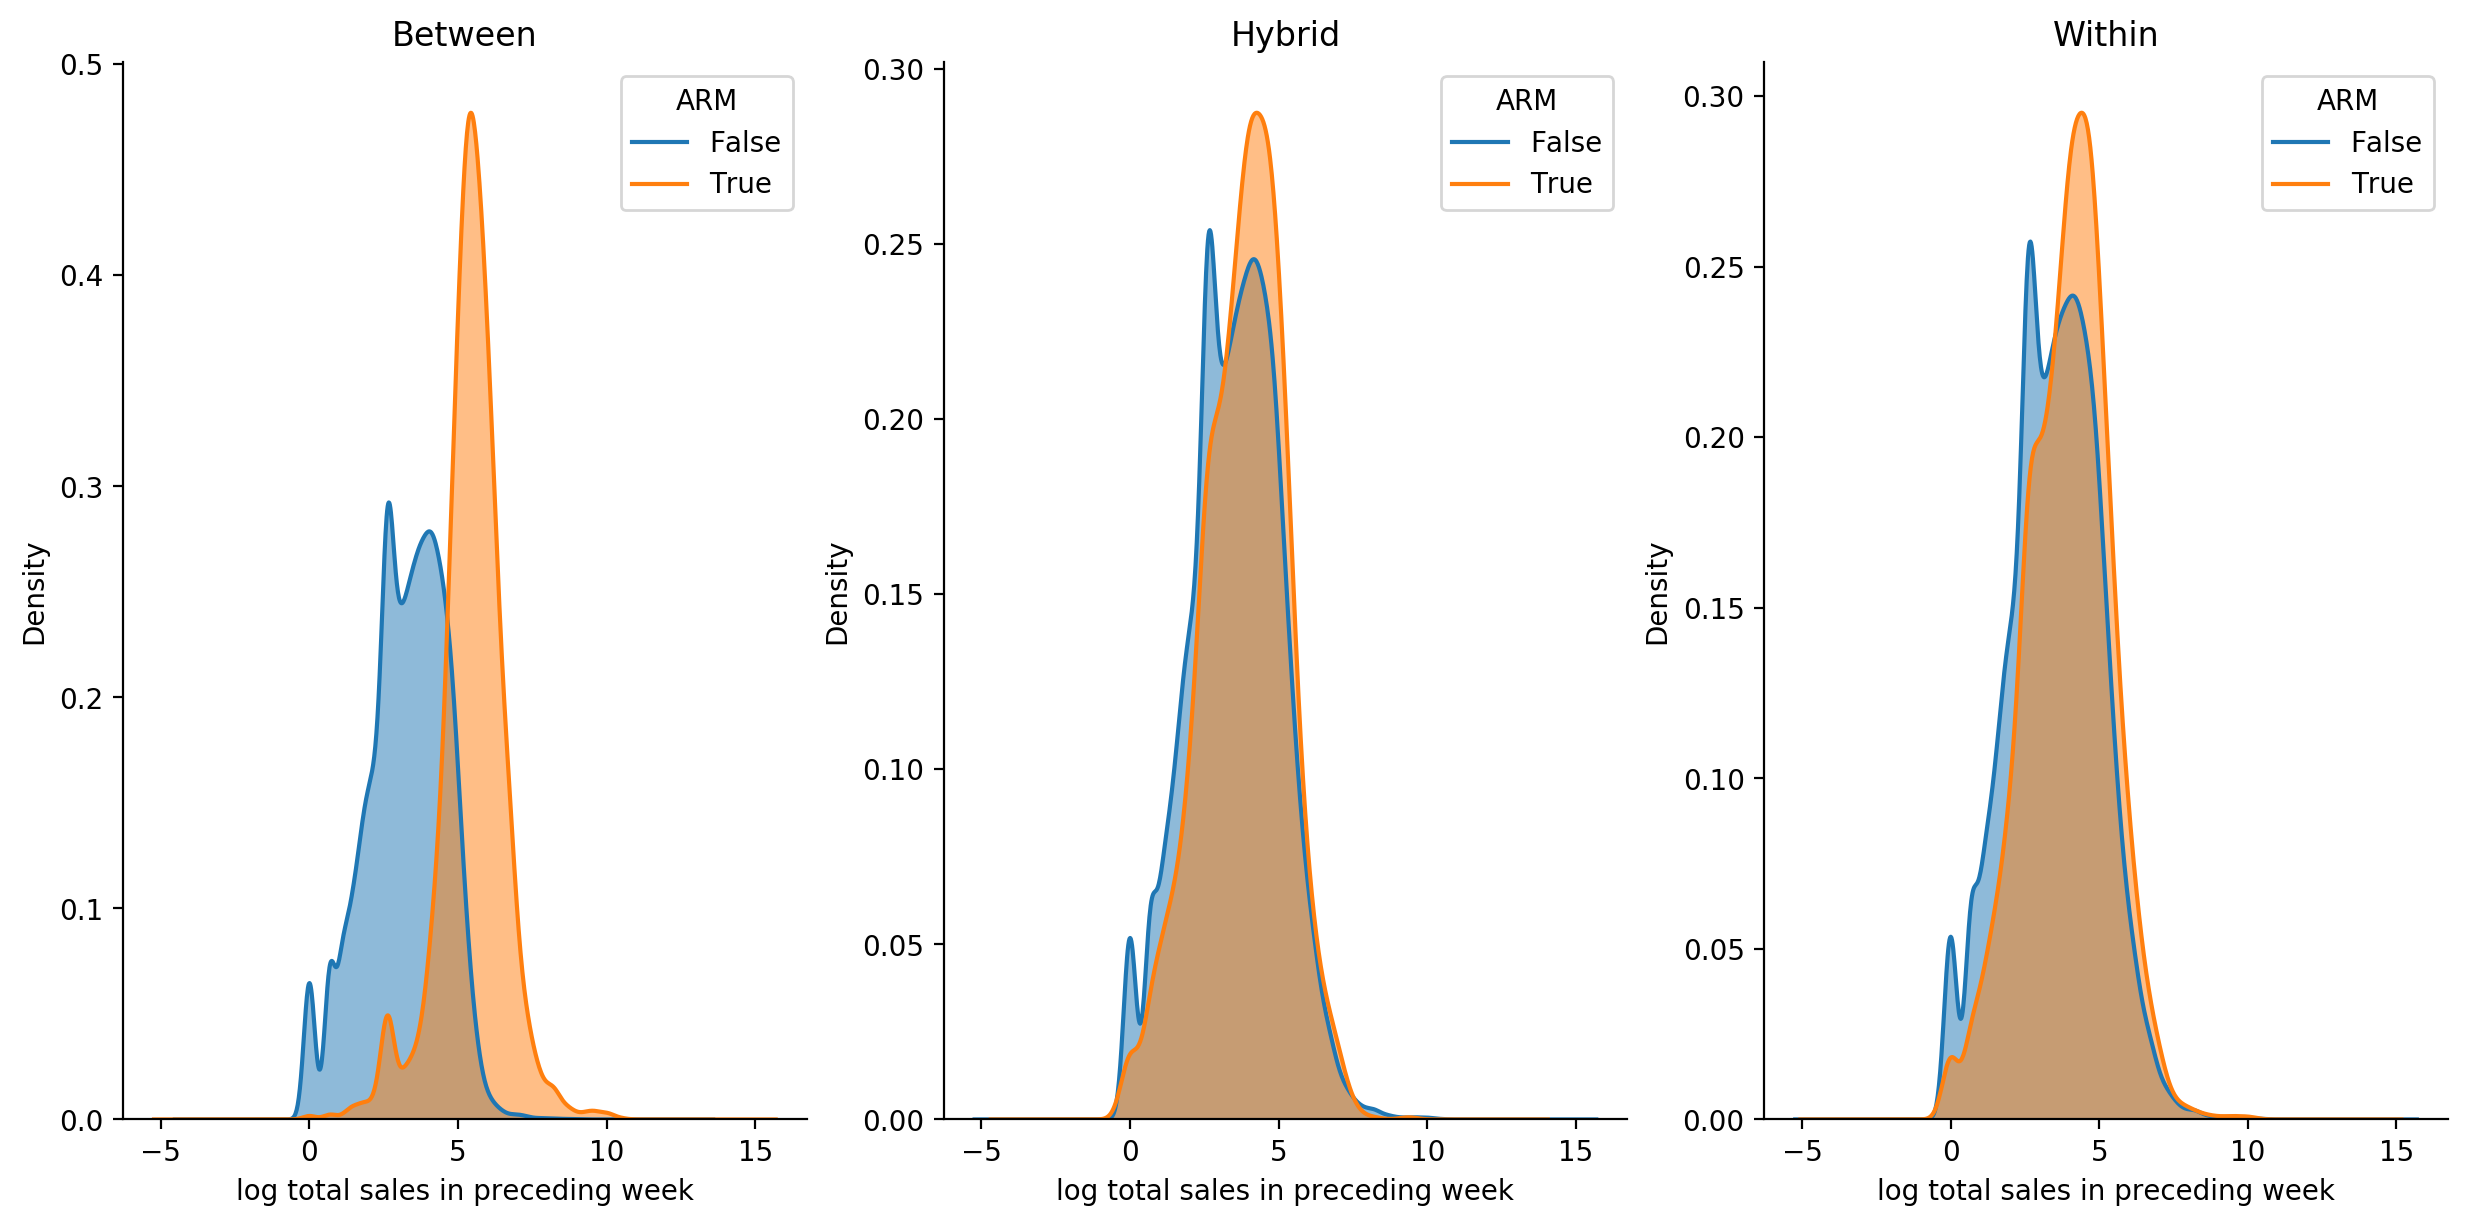

In [205]:
fig, ax = plt.subplots(ncols = 3, figsize=(15, 7))

# between vendor cut-offs
data = df.rename({'arm_maxw_shift': 'arm'}, axis = 1)\
    .assign(sales = lambda x: x['neg_count_w_shift'] + x['pos_count_w_shift'],
            prop_neg = lambda x: x['neg_count_w_shift'] / x['sales'],
            ln_sales = lambda x: x['sales'].apply(np.log))\
    .groupby('arm')['ln_sales']

for name, group in data:
    group.plot.kde(ax=ax[0], label=name)

for line in ax[0].lines:
    line = line.get_data()
    ax[0].fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
    
ax[0].legend(title = 'ARM')
ax[0].set_xlabel('log total sales in preceding week')
ax[0].set_ylim(bottom = 0)
ax[0].set_title('Between')

# Hybrid cut-offs
data = df.rename({'arm_p': 'arm'}, axis = 1)\
    .assign(sales = lambda x: x['neg_count_w_shift'] + x['pos_count_w_shift'],
            prop_neg = lambda x: x['neg_count_w_shift'] / x['sales'],
            ln_sales = lambda x: x['sales'].apply(np.log))\
    .groupby('arm')['ln_sales']

for name, group in data:
    group.plot.kde(ax=ax[1], label=name)

for line in ax[1].lines:
    line = line.get_data()
    ax[1].fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
    
ax[1].legend(title = 'ARM')
ax[1].set_xlabel('log total sales in preceding week')
ax[1].set_ylim(bottom = 0)
ax[1].set_title('Hybrid')

# Within vendor cut_offs
data = df.rename({'arm_i': 'arm'}, axis = 1)\
    .assign(sales = lambda x: x['neg_count_w_shift'] + x['pos_count_w_shift'],
            prop_neg = lambda x: x['neg_count_w_shift'] / x['sales'],
            ln_sales = lambda x: x['sales'].apply(np.log))\
    .groupby('arm')['ln_sales']

for name, group in data:
    group.plot.kde(ax=ax[2], label=name)

for line in ax[2].lines:
    line = line.get_data()
    ax[2].fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
    
ax[2].legend(title = 'ARM')
ax[2].set_xlabel('log total sales in preceding week')
ax[2].set_ylim(bottom = 0)
ax[2].set_title('Within')
    
plt.show()

the hybrid model takes into account between vendor characteristics (price) and within vendor characteristics (price, stability, and speed). this constellation assures that not all vendors have ARM identification, and does not have a bias against big sellers. 